<a href="https://colab.research.google.com/github/emmayeh-0211/Team-Topic/blob/main/%E5%B0%88%E9%A1%8C_%E9%A6%99%E8%95%89RandomForest(%E7%89%B9%E5%BE%B5%E5%B7%A5%E7%A8%8B_%E5%A4%A9%E6%B0%A3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
# 掛載google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


index：日期
input data：批發市場交易量、每日天氣、颱風警報
output answer：批發市場每日交易價格

In [43]:
!pip install joblib

In [44]:
import pandas as pd
from IPython.display import display
# 資料來自個地方
w_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/氣候資料/各縣市氣候資料_0701/dataset.csv'
p_file_path = '/content/drive/MyDrive/Ai團專_農時_共享資料夾/Dataset_資料集/模型訓練之資料集/Banana_v2.csv'
weather_df = pd.read_csv(w_file_path) # 氣候資料
weather_df.set_index(["date"], inplace=True)
price_df = pd.read_csv(p_file_path) # 香蕉的批發交易資料
filter = price_df.Market == '台北一' # 篩選出只有台北一的批發交易資料
price_df = price_df[filter]
price_df.set_index(["Date"], inplace=True)
display(weather_df.tail())
display(price_df.head())


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (130,132,305,307) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,city_KLU,StnPres_KLU,SeaPres_KLU,StnPresMax_KLU,StnPresMaxTime_KLU,StnPresMin_KLU,StnPresMinTime_KLU,Temperature_KLU,TMax_KLU,TMaxTime_KLU,TMin_KLU,TMinTime_KLU,TdDewPoint_KLU,RH_KLU,RHMin_KLU,RHMinTime_KLU,WS_KLU,WD_KLU,WSGust_KLU,WDGust_KLU,WGustTime_KLU,Precp_KLU,PrecpHour_KLU,PrecpMax10_KLU,PrecpMax10Time_KLU,PrecpMax60_KLU,PrecpMax60Time_KLU,SunShine_KLU,SunShineRate_KLU,GloblRad_KLU,VisbMean_KLU,EvapA_KLU,UVIMax_KLU,UVIMaxTime_KLU,CloudAmount_KLU,city_TPE,StnPres_TPE,SeaPres_TPE,StnPresMax_TPE,StnPresMaxTime_TPE,...,EvapA_HWA,UVIMax_HWA,UVIMaxTime_HWA,CloudAmount_HWA,city_TTT,StnPres_TTT,SeaPres_TTT,StnPresMax_TTT,StnPresMaxTime_TTT,StnPresMin_TTT,StnPresMinTime_TTT,Temperature_TTT,TMax_TTT,TMaxTime_TTT,TMin_TTT,TMinTime_TTT,TdDewPoint_TTT,RH_TTT,RHMin_TTT,RHMinTime_TTT,WS_TTT,WD_TTT,WSGust_TTT,WDGust_TTT,WGustTime_TTT,Precp_TTT,PrecpHour_TTT,PrecpMax10_TTT,PrecpMax10Time_TTT,PrecpMax60_TTT,PrecpMax60Time_TTT,SunShine_TTT,SunShineRate_TTT,GloblRad_TTT,VisbMean_TTT,EvapA_TTT,UVIMax_TTT,UVIMaxTime_TTT,CloudAmount_TTT,WarnMark
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,基隆市,997.3,1005.4,999.9,2021-06-14 00:01:00,995.3,2021-06-14 15:33:00,29.6,34.1,2021-06-14 14:15:45,27.3,2021-06-14 03:40:30,26.1,79.8,58.8,2021-06-14 12:36:45,4.7,173.2,13.6,253.0,2021-06-14 10:10:15,0.0,0.0,0.0,NaN,0.0,NaN,8.7,63.7,24.9,31.0,7.4,13.0,2021-06-14 13:00:00,7.5,臺北市,978.9,1164.5,981.5,2021-06-14 03:00:42,...,5.2,13.0,2021-06-14 12:00:00,4.1,臺東縣,966.7,1005.6,969.3,2021-06-14 00:01:25,964.9,2021-06-14 16:40:08,27.2,31.5,2021-06-14 12:35:50,23.8,2021-06-14 04:34:13,25.7,83.9,62.6,2021-06-14 11:24:30,1.6,139.8,7.4,172.0,2021-06-14 13:48:07,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.8,26.8,23.5,5.8,13.3,2021-06-14 12:40:00,4.5,0
2021-06-15,基隆市,994.7,1002.9,995.9,2021-06-15 00:01:00,993.5,2021-06-15 12:51:00,30.2,33.5,2021-06-15 13:34:45,27.6,2021-06-15 08:42:00,26.0,76.2,62.8,2021-06-15 11:08:00,6.1,231.2,16.5,253.0,2021-06-15 06:39:15,0.0,0.0,0.0,NaN,0.0,NaN,10.9,79.5,27.3,30.6,7.9,13.0,2021-06-15 12:00:00,7.2,臺北市,976.6,1156.6,977.9,2021-06-15 08:28:14,...,6.7,13.0,2021-06-15 13:00:00,4.1,臺東縣,964.6,1003.2,966.3,2021-06-15 12:02:27,963.3,2021-06-15 10:16:10,27.5,32.1,2021-06-15 11:59:22,24.2,2021-06-15 08:52:37,25.4,79.9,59.2,2021-06-15 10:56:33,2.0,148.6,9.4,166.6,2021-06-15 11:59:30,0.0,0.0,0.0,NaN,0.0,NaN,10.6,78.2,26.0,25.3,6.2,12.7,2021-06-15 12:00:00,5.2,0
2021-06-16,基隆市,995.4,1003.5,997.0,2021-06-16 21:56:30,993.4,2021-06-16 02:18:00,31.0,34.4,2021-06-16 15:19:15,27.7,2021-06-16 02:22:45,25.1,68.8,53.5,2021-06-16 15:40:00,8.7,248.8,20.4,260.2,2021-06-16 13:01:15,0.0,0.0,0.0,NaN,0.0,NaN,11.5,84.2,28.6,29.6,10.3,14.0,2021-06-16 12:00:00,2.8,臺北市,977.7,1161.4,979.4,2021-06-16 18:40:42,...,7.7,13.0,2021-06-16 12:00:00,1.9,臺東縣,965.4,1004.2,967.5,2021-06-16 21:56:45,963.5,2021-06-16 05:06:48,28.3,33.2,2021-06-16 12:44:23,24.1,2021-06-16 03:53:27,24.4,72.7,51.6,2021-06-16 13:24:10,2.3,166.5,10.4,194.7,2021-06-16 12:31:57,0.0,0.0,0.0,NaN,0.0,NaN,10.8,79.8,27.8,24.1,7.4,13.0,2021-06-16 12:20:00,4.4,0
2021-06-17,基隆市,996.9,1005.0,998.2,2021-06-17 08:58:15,995.5,2021-06-17 09:14:45,31.1,35.2,2021-06-17 13:44:00,28.0,2021-06-17 05:22:45,25.3,68.8,54.8,2021-06-17 14:04:00,7.9,233.2,18.1,243.2,2021-06-17 06:48:15,0.0,0.0,0.0,NaN,0.0,NaN,11.1,81.3,26.2,23.9,8.6,13.0,2021-06-17 12:00:00,5.8,臺北市,979.0,1166.5,980.5,2021-06-17 08:18:46,...,6.1,13.0,2021-06-17 12:00:00,1.5,臺東縣,966.8,1005.4,968.2,2021-06-17 20:23:43,965.5,2021-06-17 14:22:05,28.4,33.0,2021-06-17 12:45:47,24.9,2021-06-17 10:27:33,24.5,72.5,52.4,2021-06-17 12:09:22,2.0,164.5,9.0,151.5,2021-06-17 14:03:52,0.0,0.0,0.0,NaN,0.0,NaN,10.2,75.2,27.2,25.0,7.2,13.0,2021-06-17 12:00:00,2.5,0
2021-06-18,基隆市,995.5,1003.6,997.1,2021-06-18 03:47:30,993.5,2021-06-18 15:39:30,31.3,35.4,2021-06-18 13:46:15,28.4,2021-06-18 03:33:15,25.4,68.0,50.5,2021-06-18 13:44:45,8.0,232.5,18.7,239.8,2021-06-18 07:33:30,0.0,0.0,0.0,NaN,0.0,NaN,10.3,75.5,26.6,25.8,9.2,14.0,2021-06-18 12:00:0

,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Avg_price_diff,Volume,Volume_diff,Month,Week_day,Year,Rest_day
Date,,,,,,,,,,,,,
2000-01-02,台北一,A1 香蕉,30.0,22.0,14.0,20.2,NaN,22319.0,NaN,1,7,2000,0
2000-01-03,台北一,A1 香蕉,26.0,18.0,12.0,19.5,-3.47,15810.0,-29.16,1,1,2000,0
2000-01-04,台北一,A1 香蕉,28.0,18.0,12.0,20.3,4.10,15126.0,-4.33,1,2,2000,0
2000-01-05,台北一,A1 香蕉,28.0,20.0,10.0,20.0,-1.48,18693.0,23.58,1,3,2000,0
2000-01-06,台北一,A1 香蕉,28.0,20.0,10.0,20.3,1.50,22677.0,21.31,1,4,2000,0


先處理市場批發交易資料：Date、Market、product、Up_price、Mid_price、Low_price、	Avg_price、Volume、Month、Week_day、Year、Rest_day。


---
* 抓出不含休市資料的表格（使用loc不用drop）
* 加入前7天的市場交易資訊（不包含休市了，因此若中間日期有休市日會自動跳過）
* 加入累積7天平均交易資訊
* 加入要預測日的均價（3天後的均價）



In [45]:
# 將市場資料中的
filter = price_df.Rest_day == 0 # 休市日標記為0
indexNames = price_df[filter].index # 符合filter的index們
newprice_df = price_df.loc[indexNames,:] # 使用新的df
newprice_df.Rest_day.value_counts() # 休市日部分只剩下標注為0的資料了

0    6502
Name: Rest_day, dtype: int64

In [46]:
# # 加入前6天的交易資訊
# for day in range(1, 7):
#   columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
#   temp_df = newprice_df.loc[:, columns]
#   shifted_df=temp_df.shift(periods=day)
#   shifted_df = shifted_df.add_suffix('_' + str(day) + 'days_ago')
#   newprice_df = pd.merge(newprice_df, shifted_df, how='outer', left_index=True, right_index=True)
# newprice_df

In [47]:
# # 加入過去一周價格資料的平均
# # 方法二，把上面找到的資料加起來做平均
# columns = ['Up_price', 'Mid_price', 'Low_price', 'Avg_price', 'Volume']
# for c in columns:
#   c_list = list()
#   for w in newprice_df.columns:
#     if c in w:
#       c_list.append(w)
#   temp_df = newprice_df.loc[:, c_list]
#   display(temp_df)
#   newprice_df[c + '_mean'] = temp_df.mean(axis=1)
# newprice_df.tail()

In [48]:
# 要預測的答案為7天後的價格，因此把7天後的價格加入
shifted_df=newprice_df.Avg_price.shift(periods=-7)
newprice_df['ans_price'] = shifted_df
newprice_df.loc[:,['Avg_price', 'ans_price']].tail(10)

,Avg_price,ans_price
Date,,
2021-06-08,24.4,23.2
2021-06-09,23.5,20.9
2021-06-10,25.8,24.8
2021-06-11,25.1,NaN
2021-06-12,25.3,NaN
2021-06-13,26.1,NaN
2021-06-14,26.6,NaN
2021-06-17,23.2,NaN
2021-06-18,20.9,NaN


In [49]:
# 天氣欄位太多，因此只保留 氣溫、最高溫、最低溫、風速、最大風速、雨量 這6個因素
# 並新增溫差的因素
# 縣市：先放所有縣市
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}
factors = ['Temperature_', 'TMax_', 'TMin_', 'WS_', 'WSGust_', 'Precp_']
newweather_df = pd.DataFrame()
newweather_df['WarnMark'] = weather_df['WarnMark']
for c in weather_df:
  for f in factors:
    if c.startswith(f):
      newweather_df[c] = weather_df[c]

for city in city.values():
  TMax = newweather_df['TMax_'+city]
  TMin = newweather_df['TMin_'+city]
  newweather_df['Tempdff_'+city] = TMax - TMin
newweather_df.tail()

,WarnMark,Temperature_KLU,TMax_KLU,TMin_KLU,WS_KLU,WSGust_KLU,Precp_KLU,Temperature_TPE,TMax_TPE,TMin_TPE,WS_TPE,WSGust_TPE,Precp_TPE,Temperature_TPH,TMax_TPH,TMin_TPH,WS_TPH,WSGust_TPH,Precp_TPH,Temperature_TYC,TMax_TYC,TMin_TYC,WS_TYC,WSGust_TYC,Precp_TYC,Temperature_HSC,TMax_HSC,TMin_HSC,WS_HSC,WSGust_HSC,Precp_HSC,Temperature_HSH,TMax_HSH,TMin_HSH,WS_HSH,WSGust_HSH,Precp_HSH,Temperature_MAL,TMax_MAL,TMin_MAL,...,WS_IUH,WSGust_IUH,Precp_IUH,Temperature_ILN,TMax_ILN,TMin_ILN,WS_ILN,WSGust_ILN,Precp_ILN,Temperature_HWA,TMax_HWA,TMin_HWA,WS_HWA,WSGust_HWA,Precp_HWA,Temperature_TTT,TMax_TTT,TMin_TTT,WS_TTT,WSGust_TTT,Precp_TTT,Tempdff_KLU,Tempdff_TPE,Tempdff_TPH,Tempdff_TYC,Tempdff_HSC,Tempdff_HSH,Tempdff_MAL,Tempdff_TXG,Tempdff_CWH,Tempdff_NTO,Tempdff_YLH,Tempdff_CYI,Tempdff_CHY,Tempdff_TNN,Tempdff_KHH,Tempdff_IUH,Tempdff_ILN,Tempdff_HWA,Tempdff_TTT
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,0,29.6,34.1,27.3,4.7,13.6,0.0,29.1,34.7,25.4,2.1,9.5,0.0,28.8,33.7,25.1,1.9,10.0,0.0,29.0,33.0,25.8,2.2,9.5,0.0,29.6,33.0,27.2,2.2,10.2,0.0,27.3,31.9,23.5,1.1,7.1,0.0,28.9,33.6,25.6,...,2.7,10.1,0.4,26.0,31.3,22.7,1.2,6.2,1.5,26.4,31.8,22.5,1.0,6.3,0.2,27.2,31.5,23.8,1.6,7.4,0.0,6.8,9.3,8.6,7.2,5.8,8.4,8.0,8.3,8.3,10.2,8.3,9.1,8.4,8.5,7.6,6.6,8.6,9.3,7.7
2021-06-15,0,30.2,33.5,27.6,6.1,16.5,0.0,29.4,33.3,26.1,2.5,11.7,0.0,28.9,33.2,25.5,2.2,11.2,0.0,29.3,32.6,26.2,2.7,11.8,0.0,29.9,32.7,27.7,2.9,12.1,0.0,28.0,31.4,24.4,1.6,10.1,0.0,29.4,32.8,26.2,...,2.4,9.7,4.9,26.4,31.3,22.6,1.2,5.6,0.0,27.1,32.0,23.0,1.0,5.9,0.0,27.5,32.1,24.2,2.0,9.4,0.0,5.9,7.2,7.7,6.4,5.0,7.0,6.6,6.6,6.6,8.3,6.3,6.6,6.6,6.3,6.2,4.9,8.7,9.0,7.9
2021-06-16,0,31.0,34.4,27.7,8.7,20.4,0.0,30.0,34.7,26.5,2.8,14.1,0.0,29.7,34.3,25.7,2.7,13.8,0.0,29.9,33.5,26.7,3.4,14.5,0.0,30.7,34.7,27.9,3.5,12.8,0.0,28.5,32.6,24.8,2.0,11.6,0.0,29.1,32.5,25.6,...,2.9,11.5,30.1,27.1,31.9,23.2,1.4,5.8,0.4,27.8,33.8,23.3,1.0,6.2,0.0,28.3,33.2,24.1,2.3,10.4,0.0,6.7,8.2,8.6,6.8,6.8,7.8,6.9,7.0,6.5,6.7,6.3,6.3,6.0,5.9,4.5,3.8,8.7,10.5,9.1
2021-06-17,0,31.1,35.2,28.0,7.9,18.1,0.0,30.2,35.0,26.6,2.7,11.7,0.0,29.8,34.8,25.6,2.5,11.5,0.0,30.0,34.0,26.8,3.3,12.7,0.0,30.8,34.2,28.4,3.3,13.4,0.0,28.8,33.2,25.0,1.9,10.0,0.0,29.8,34.2,26.7,...,2.8,11.0,5.3,27.4,32.8,23.2,1.3,5.8,0.2,28.0,34.0,23.7,0.9,5.8,0.0,28.4,33.0,24.9,2.0,9.0,0.0,7.2,8.4,9.2,7.2,5.8,8.2,7.5,7.6,7.5,9.4,7.5,7.8,7.3,6.8,7.0,5.4,9.6,10.3,8.1
2021-06-18,0,31.3,35.4,28.4,8.0,18.7,0.0,30.7,35.7,27.1,2.7,12.6,0.0,30.1,35.2,26.3,2.5,12.5,0.0,30.3,34.4,27.0,3.3,12.8,0.0,30.8,34.2,28.4,3.4,12.0,0.0,28.8,33.2,25.6,1.9,10.1,0.0,29.9,34.0,26.8,...,2.9,11.3,4.3,27.4,32.5,23.6,1.2,5.3,0.1,28.1,34.0,23.6,0.8,5.3,0.0,28.4,33.1,24.8,1.8,7.9,0.0,7.0,8.6,8.9,7.4,5.8,7.6,7.2,7.7,7.9,8.6,7.1,7.0,7.1,7.2,6.9,5.8,8.9,10.4,8.3


In [50]:
# 天氣資料前處理
# 以三個月為一期
# 天數區間：7天 / 15天 / 30天 / 90天
# 氣溫 過去90天平均溫度 mean(O)
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# 溫差 過去90天溫差的標準差 std

days = [7, 15, 30, 90]
c_list=list()
name_list=list()

for num, name in enumerate(newweather_df.columns):
  if 'Temperature' in name:
    c_list.append(num)
    name_list.append(name)
temperature_df = newweather_df.loc[:,name_list]
for day in days:
  white_df = pd.DataFrame(index=newweather_df.index,columns=name_list)
  white_df = white_df.add_suffix(f'_mean_of_{day}days')
  for start in range(len(newweather_df.index)):
    d = newweather_df.iloc[start:start+day-1,c_list].mean(axis=0)
    d = d.add_suffix(f'_mean_of_{day}days')
    white_df.iloc[start]=d
  temperature_df = pd.merge(temperature_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內
temperature_df.tail()

,Temperature_KLU,Temperature_TPE,Temperature_TPH,Temperature_TYC,Temperature_HSC,Temperature_HSH,Temperature_MAL,Temperature_TXG,Temperature_CWH,Temperature_NTO,Temperature_YLH,Temperature_CYI,Temperature_CHY,Temperature_TNN,Temperature_KHH,Temperature_IUH,Temperature_ILN,Temperature_HWA,Temperature_TTT,Temperature_KLU_mean_of_7days,Temperature_TPE_mean_of_7days,Temperature_TPH_mean_of_7days,Temperature_TYC_mean_of_7days,Temperature_HSC_mean_of_7days,Temperature_HSH_mean_of_7days,Temperature_MAL_mean_of_7days,Temperature_TXG_mean_of_7days,Temperature_CWH_mean_of_7days,Temperature_NTO_mean_of_7days,Temperature_YLH_mean_of_7days,Temperature_CYI_mean_of_7days,Temperature_CHY_mean_of_7days,Temperature_TNN_mean_of_7days,Temperature_KHH_mean_of_7days,Temperature_IUH_mean_of_7days,Temperature_ILN_mean_of_7days,Temperature_HWA_mean_of_7days,Temperature_TTT_mean_of_7days,Temperature_KLU_mean_of_15days,Temperature_TPE_mean_of_15days,...,Temperature_HWA_mean_of_15days,Temperature_TTT_mean_of_15days,Temperature_KLU_mean_of_30days,Temperature_TPE_mean_of_30days,Temperature_TPH_mean_of_30days,Temperature_TYC_mean_of_30days,Temperature_HSC_mean_of_30days,Temperature_HSH_mean_of_30days,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,Temperature_NTO_mean_of_30days,Temperature_YLH_mean_of_30days,Temperature_CYI_mean_of_30days,Temperature_CHY_mean_of_30days,Temperature_TNN_mean_of_30days,Temperature_KHH_mean_of_30days,Temperature_IUH_mean_of_30days,Temperature_ILN_mean_of_30days,Temperature_HWA_mean_of_30days,Temperature_TTT_mean_of_30days,Temperature_KLU_mean_of_90days,Temperature_TPE_mean_of_90days,Temperature_TPH_mean_of_90days,Temperature_TYC_mean_of_90days,Temperature_HSC_mean_of_90days,Temperature_HSH_mean_of_90days,Temperature_MAL_mean_of_90days,Temperature_TXG_mean_of_90days,Temperature_CWH_mean_of_90days,Temperature_NTO_mean_of_90days,Temperature_YLH_mean_of_90days,Temperature_CYI_mean_of_90days,Temperature_CHY_mean_of_90days,Temperature_TNN_mean_of_90days,Temperature_KHH_mean_of_90days,Temperature_IUH_mean_of_90days,Temperature_ILN_mean_of_90days,Temperature_HWA_mean_of_90days,Temperature_TTT_mean_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,29.6,29.1,28.8,29.0,29.6,27.3,28.9,26.0,29.5,22.6,28.9,29.9,27.2,29.4,29.4,28.2,26.0,26.4,27.2,30.64,29.88,29.46,29.7,30.36,28.28,29.42,25.96,29.38,22.16,28.7,29.4,26.64,28.64,28.36,27.52,26.86,27.48,27.96,30.64,29.88,...,27.48,27.96,30.64,29.88,29.46,29.7,30.36,28.28,29.42,25.96,29.38,22.16,28.7,29.4,26.64,28.64,28.36,27.52,26.86,27.48,27.96,30.64,29.88,29.46,29.7,30.36,28.28,29.42,25.96,29.38,22.16,28.7,29.4,26.64,28.64,28.36,27.52,26.86,27.48,27.96
2021-06-15,30.2,29.4,28.9,29.3,29.9,28.0,29.4,26.3,29.7,22.8,29.0,29.8,26.9,28.9,29.0,27.7,26.4,27.1,27.5,30.9,30.075,29.625,29.875,30.55,28.525,29.55,25.95,29.35,22.05,28.65,29.275,26.5,28.45,28.1,27.35,27.075,27.75,28.15,30.9,30.075,...,27.75,28.15,30.9,30.075,29.625,29.875,30.55,28.525,29.55,25.95,29.35,22.05,28.65,29.275,26.5,28.45,28.1,27.35,27.075,27.75,28.15,30.9,30.075,29.625,29.875,30.55,28.525,29.55,25.95,29.35,22.05,28.65,29.275,26.5,28.45,28.1,27.35,27.075,27.75,28.15
2021-06-16,31.0,30.0,29.7,29.9,30.7,28.5,29.1,25.0,28.3,21.2,27.6,27.9,25.6,27.9,27.3,26.6,27.1,27.8,28.3,31.1333,30.3,29.8667,30.0667,30.7667,28.7,29.6,25.8333,29.2333,21.8,28.5333,29.1,26.3667,28.3,27.8,27.2333,27.3,27.9667,28.3667,31.1333,30.3,...,27.9667,28.3667,31.1333,30.3,29.8667,30.0667,30.7667,28.7,29.6,25.8333,29.2333,21.8,28.5333,29.1,26.3667,28.3,27.8,27.2333,27.3,27.9667,28.3667,31.1333,30.3,29.8667,30.0667,30.7667,28.7,29.6,25.8333,29.2333,21.8,28.5333,29.1,26.3667,28.3,27.8,27.2333,27.3,27.9667,28.3667
2021-06-17,31.1,30.2,29.8,30.0,30.8,28.8,29.8,26.2,29.5,21.9,28.7,29.3,26.4,28.1,27.9,27.4,27.4,28.0,28.4,31.2,30.45,29.95,30.15,30.8,28.8,29.85,26.25,29.7,22.1,29,29.7,26.75,28.5,28.05,27.55,27.4,28.05,28.4,31.2,30.45,...,28.05,28.4,31.2,30.45,29.95,30.15,3

In [51]:
# 天氣資料前處理
# 以三個月為一期
# 天數區間：7天 / 15天 / 30天 / 90天
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max(O)
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# 溫差 過去90天溫差的標準差 std

days = [7, 15, 30, 90]
c_list=list()
name_list=list()
for num, name in enumerate(newweather_df.columns):
  if 'TMax' in name:
    c_list.append(num)
    name_list.append(name)
T_max_df = newweather_df.loc[:,name_list]
for day in days:
  white_df = pd.DataFrame(index=newweather_df.index,columns=name_list)
  white_df = white_df.add_suffix(f'_max_of_{day}days')
  for start in range(len(newweather_df.index)):
    d = newweather_df.iloc[start:start+day-1,c_list].max(axis=0)
    d = d.add_suffix(f'_max_of_{day}days')
    white_df.iloc[start]=d
  T_max_df = pd.merge(T_max_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內
T_max_df.tail()

,TMax_KLU,TMax_TPE,TMax_TPH,TMax_TYC,TMax_HSC,TMax_HSH,TMax_MAL,TMax_TXG,TMax_CWH,TMax_NTO,TMax_YLH,TMax_CYI,TMax_CHY,TMax_TNN,TMax_KHH,TMax_IUH,TMax_ILN,TMax_HWA,TMax_TTT,TMax_KLU_max_of_7days,TMax_TPE_max_of_7days,TMax_TPH_max_of_7days,TMax_TYC_max_of_7days,TMax_HSC_max_of_7days,TMax_HSH_max_of_7days,TMax_MAL_max_of_7days,TMax_TXG_max_of_7days,TMax_CWH_max_of_7days,TMax_NTO_max_of_7days,TMax_YLH_max_of_7days,TMax_CYI_max_of_7days,TMax_CHY_max_of_7days,TMax_TNN_max_of_7days,TMax_KHH_max_of_7days,TMax_IUH_max_of_7days,TMax_ILN_max_of_7days,TMax_HWA_max_of_7days,TMax_TTT_max_of_7days,TMax_KLU_max_of_15days,TMax_TPE_max_of_15days,...,TMax_HWA_max_of_15days,TMax_TTT_max_of_15days,TMax_KLU_max_of_30days,TMax_TPE_max_of_30days,TMax_TPH_max_of_30days,TMax_TYC_max_of_30days,TMax_HSC_max_of_30days,TMax_HSH_max_of_30days,TMax_MAL_max_of_30days,TMax_TXG_max_of_30days,TMax_CWH_max_of_30days,TMax_NTO_max_of_30days,TMax_YLH_max_of_30days,TMax_CYI_max_of_30days,TMax_CHY_max_of_30days,TMax_TNN_max_of_30days,TMax_KHH_max_of_30days,TMax_IUH_max_of_30days,TMax_ILN_max_of_30days,TMax_HWA_max_of_30days,TMax_TTT_max_of_30days,TMax_KLU_max_of_90days,TMax_TPE_max_of_90days,TMax_TPH_max_of_90days,TMax_TYC_max_of_90days,TMax_HSC_max_of_90days,TMax_HSH_max_of_90days,TMax_MAL_max_of_90days,TMax_TXG_max_of_90days,TMax_CWH_max_of_90days,TMax_NTO_max_of_90days,TMax_YLH_max_of_90days,TMax_CYI_max_of_90days,TMax_CHY_max_of_90days,TMax_TNN_max_of_90days,TMax_KHH_max_of_90days,TMax_IUH_max_of_90days,TMax_ILN_max_of_90days,TMax_HWA_max_of_90days,TMax_TTT_max_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,34.1,34.7,33.7,33.0,33.0,31.9,33.6,30.9,34.2,28.6,33.5,34.6,32.1,33.8,33.2,31.7,31.3,31.8,31.5,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.9,34.2,28.6,33.5,34.6,32.1,33.8,33.2,31.7,32.8,34,33.2,35.4,35.7,...,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.9,34.2,28.6,33.5,34.6,32.1,33.8,33.2,31.7,32.8,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.9,34.2,28.6,33.5,34.6,32.1,33.8,33.2,31.7,32.8,34,33.2
2021-06-15,33.5,33.3,33.2,32.6,32.7,31.4,32.8,30.1,33.3,27.7,32.3,33.8,30.5,32.6,32.5,30.5,31.3,32.0,32.1,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.7,33,34.1,31.2,32.9,32.5,30.9,32.8,34,33.2,35.4,35.7,...,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.7,33,34.1,31.2,32.9,32.5,30.9,32.8,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.7,33,34.1,31.2,32.9,32.5,30.9,32.8,34,33.2
2021-06-16,34.4,34.7,34.3,33.5,34.7,32.6,32.5,28.7,31.9,25.3,31.0,30.8,28.9,31.4,29.9,28.6,31.9,33.8,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.2,35.4,35.7,...,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.2,35.4,35.7,35.2,34.4,34.7,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.2
2021-06-17,35.2,35.0,34.8,34.0,34.2,33.2,34.2,30.6,33.8,27.5,32.5,34.0,30.6,32.3,32.1,30.6,32.8,34.0,33.0,35.4,35.7,35.2,34.4,34.2,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.1,35.4,35.7,...,34,33.1,35.4,35.7,35.2,34.4,34.2,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.1,35.4,35.7,35.2,34.4,34.2,33.2,34.2,30.6,34.1,27.5,33,34.1,31.2,32.9,32.2,30.9,32.8,34,33.1
2021-06-18,35.4,35.7,35.2,34.4,34.2,33.2,34.0,30.6,34.1,27.3,33.0,34.1,31.2,32.9,32.2,30.9,32.5,34.0,33.1,35.4,35.7,35.2,34.4,34.2,33.2,34,30.6,34.1,27.3,33,34.1,31.2,32.9,32.2,30.9,32.5,34,33.1,35.4,35.7,...,34,33.1,35.4,35.7,35.2,34.4,34.2,33.2,34,30.6,34.1,27.3,33,34.1,31.2,32.9,32.2,30.9,32.5,34,33.1,35.4,35.7,35.2,34.4,34.2,33.2,34,30.6,34.1,27.3,33,34.1,31.2,32.9,32.2,30.9,32.5,34,33.1


In [52]:
# 天氣資料前處理
# 以三個月為一期
# 天數區間：7天 / 15天 / 30天 / 90天
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min(O)
# 雨量 過去90天累積雨量 sum
# 溫差 過去90天溫差的標準差 std

days = [7, 15, 30, 90]
c_list=list()
name_list=list()

for num, name in enumerate(newweather_df.columns):
  if 'TMin' in name:
    c_list.append(num)
    name_list.append(name)
T_min_df = newweather_df.loc[:,name_list]
for day in days:
  white_df = pd.DataFrame(index=newweather_df.index,columns=name_list)
  white_df = white_df.add_suffix(f'_min_of_{day}days')
  for start in range(len(newweather_df.index)):
    d = newweather_df.iloc[start:start+day-1,c_list].min(axis=0)
    d = d.add_suffix(f'_min_of_{day}days')
    white_df.iloc[start]=d
  T_min_df = pd.merge(T_min_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內
T_min_df.tail()

,TMin_KLU,TMin_TPE,TMin_TPH,TMin_TYC,TMin_HSC,TMin_HSH,TMin_MAL,TMin_TXG,TMin_CWH,TMin_NTO,TMin_YLH,TMin_CYI,TMin_CHY,TMin_TNN,TMin_KHH,TMin_IUH,TMin_ILN,TMin_HWA,TMin_TTT,TMin_KLU_min_of_7days,TMin_TPE_min_of_7days,TMin_TPH_min_of_7days,TMin_TYC_min_of_7days,TMin_HSC_min_of_7days,TMin_HSH_min_of_7days,TMin_MAL_min_of_7days,TMin_TXG_min_of_7days,TMin_CWH_min_of_7days,TMin_NTO_min_of_7days,TMin_YLH_min_of_7days,TMin_CYI_min_of_7days,TMin_CHY_min_of_7days,TMin_TNN_min_of_7days,TMin_KHH_min_of_7days,TMin_IUH_min_of_7days,TMin_ILN_min_of_7days,TMin_HWA_min_of_7days,TMin_TTT_min_of_7days,TMin_KLU_min_of_15days,TMin_TPE_min_of_15days,...,TMin_HWA_min_of_15days,TMin_TTT_min_of_15days,TMin_KLU_min_of_30days,TMin_TPE_min_of_30days,TMin_TPH_min_of_30days,TMin_TYC_min_of_30days,TMin_HSC_min_of_30days,TMin_HSH_min_of_30days,TMin_MAL_min_of_30days,TMin_TXG_min_of_30days,TMin_CWH_min_of_30days,TMin_NTO_min_of_30days,TMin_YLH_min_of_30days,TMin_CYI_min_of_30days,TMin_CHY_min_of_30days,TMin_TNN_min_of_30days,TMin_KHH_min_of_30days,TMin_IUH_min_of_30days,TMin_ILN_min_of_30days,TMin_HWA_min_of_30days,TMin_TTT_min_of_30days,TMin_KLU_min_of_90days,TMin_TPE_min_of_90days,TMin_TPH_min_of_90days,TMin_TYC_min_of_90days,TMin_HSC_min_of_90days,TMin_HSH_min_of_90days,TMin_MAL_min_of_90days,TMin_TXG_min_of_90days,TMin_CWH_min_of_90days,TMin_NTO_min_of_90days,TMin_YLH_min_of_90days,TMin_CYI_min_of_90days,TMin_CHY_min_of_90days,TMin_TNN_min_of_90days,TMin_KHH_min_of_90days,TMin_IUH_min_of_90days,TMin_ILN_min_of_90days,TMin_HWA_min_of_90days,TMin_TTT_min_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,27.3,25.4,25.1,25.8,27.2,23.5,25.6,22.6,25.9,18.4,25.2,25.5,23.7,25.3,25.6,25.1,22.7,22.5,23.8,27.3,25.4,25.1,25.8,27.2,23.5,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.3,25.1,24.8,22.6,22.5,23.8,27.3,25.4,...,22.5,23.8,27.3,25.4,25.1,25.8,27.2,23.5,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.3,25.1,24.8,22.6,22.5,23.8,27.3,25.4,25.1,25.8,27.2,23.5,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.3,25.1,24.8,22.6,22.5,23.8
2021-06-15,27.6,26.1,25.5,26.2,27.7,24.4,26.2,23.5,26.7,19.4,26.0,27.2,23.9,26.3,26.3,25.6,22.6,23.0,24.2,27.6,26.1,25.5,26.2,27.7,24.4,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,22.6,23,24.1,27.6,26.1,...,23,24.1,27.6,26.1,25.5,26.2,27.7,24.4,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,22.6,23,24.1,27.6,26.1,25.5,26.2,27.7,24.4,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,22.6,23,24.1
2021-06-16,27.7,26.5,25.7,26.7,27.9,24.8,25.6,21.7,25.4,18.6,24.7,24.5,22.9,25.5,25.4,24.8,23.2,23.3,24.1,27.7,26.5,25.6,26.7,27.9,24.8,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,23.2,23.3,24.1,27.7,26.5,...,23.3,24.1,27.7,26.5,25.6,26.7,27.9,24.8,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,23.2,23.3,24.1,27.7,26.5,25.6,26.7,27.9,24.8,25.6,21.7,25.4,18.1,24.7,24.5,22.9,25.5,25.1,24.8,23.2,23.3,24.1
2021-06-17,28.0,26.6,25.6,26.8,28.4,25.0,26.7,23.0,26.3,18.1,25.0,26.2,23.3,25.5,25.1,25.2,23.2,23.7,24.9,28,26.6,25.6,26.8,28.4,25,26.7,22.9,26.2,18.1,25,26.2,23.3,25.5,25.1,25.1,23.2,23.6,24.8,28,26.6,...,23.6,24.8,28,26.6,25.6,26.8,28.4,25,26.7,22.9,26.2,18.1,25,26.2,23.3,25.5,25.1,25.1,23.2,23.6,24.8,28,26.6,25.6,26.8,28.4,25,26.7,22.9,26.2,18.1,25,26.2,23.3,25.5,25.1,25.1,23.2,23.6,24.8
2021-06-18,28.4,27.1,26.3,27.0,28.4,25.6,26.8,22.9,26.2,18.7,25.9,27.1,24.1,25.7,25.3,25.1,23.6,23.6,24.8,28.4,27.1,26.3,27,28.4,25.6,26.8,22.9,26.2,18.7,25.9,27.1,24.1,25.7,25.3,25.1,23.6,23.6,24.8,28.4,27.1,...,23.6,24.8,28.4,27.1,26.3,27,28.4,25.6,26.8,22.9,26.2,18.7,25.9,27.1,24.1,25.7,25.3,25.1,23.6,23.6,24.8,28.4,27.1,26.3,27,28.4,25.6,26.8,22.9,26.2,18.7,25.9,27.1,24.1,25.7,25.3,25.1,23.6,23.6,24.8


In [53]:
# 天氣資料前處理
# 以三個月為一期
# 天數區間：7天 / 15天 / 30天 / 90天
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum(O)
# 溫差 過去90天溫差的標準差 std

days = [7, 15, 30, 90]
c_list=list()
name_list=list()
for num, name in enumerate(newweather_df.columns):
  if 'Precp' in name:
    c_list.append(num)
    name_list.append(name)
Precp_df = newweather_df.loc[:,name_list]
for day in days:
  white_df = pd.DataFrame(index=newweather_df.index,columns=name_list)
  white_df = white_df.add_suffix(f'_sum_of_{day}days')
  for start in range(len(newweather_df.index)):
    d = newweather_df.iloc[start:start+day-1,c_list].sum(axis=0)
    d = d.add_suffix(f'_sum_of_{day}days')
    white_df.iloc[start]=d
  Precp_df = pd.merge(Precp_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內
Precp_df.tail()

,Precp_KLU,Precp_TPE,Precp_TPH,Precp_TYC,Precp_HSC,Precp_HSH,Precp_MAL,Precp_TXG,Precp_CWH,Precp_NTO,Precp_YLH,Precp_CYI,Precp_CHY,Precp_TNN,Precp_KHH,Precp_IUH,Precp_ILN,Precp_HWA,Precp_TTT,Precp_KLU_sum_of_7days,Precp_TPE_sum_of_7days,Precp_TPH_sum_of_7days,Precp_TYC_sum_of_7days,Precp_HSC_sum_of_7days,Precp_HSH_sum_of_7days,Precp_MAL_sum_of_7days,Precp_TXG_sum_of_7days,Precp_CWH_sum_of_7days,Precp_NTO_sum_of_7days,Precp_YLH_sum_of_7days,Precp_CYI_sum_of_7days,Precp_CHY_sum_of_7days,Precp_TNN_sum_of_7days,Precp_KHH_sum_of_7days,Precp_IUH_sum_of_7days,Precp_ILN_sum_of_7days,Precp_HWA_sum_of_7days,Precp_TTT_sum_of_7days,Precp_KLU_sum_of_15days,Precp_TPE_sum_of_15days,...,Precp_HWA_sum_of_15days,Precp_TTT_sum_of_15days,Precp_KLU_sum_of_30days,Precp_TPE_sum_of_30days,Precp_TPH_sum_of_30days,Precp_TYC_sum_of_30days,Precp_HSC_sum_of_30days,Precp_HSH_sum_of_30days,Precp_MAL_sum_of_30days,Precp_TXG_sum_of_30days,Precp_CWH_sum_of_30days,Precp_NTO_sum_of_30days,Precp_YLH_sum_of_30days,Precp_CYI_sum_of_30days,Precp_CHY_sum_of_30days,Precp_TNN_sum_of_30days,Precp_KHH_sum_of_30days,Precp_IUH_sum_of_30days,Precp_ILN_sum_of_30days,Precp_HWA_sum_of_30days,Precp_TTT_sum_of_30days,Precp_KLU_sum_of_90days,Precp_TPE_sum_of_90days,Precp_TPH_sum_of_90days,Precp_TYC_sum_of_90days,Precp_HSC_sum_of_90days,Precp_HSH_sum_of_90days,Precp_MAL_sum_of_90days,Precp_TXG_sum_of_90days,Precp_CWH_sum_of_90days,Precp_NTO_sum_of_90days,Precp_YLH_sum_of_90days,Precp_CYI_sum_of_90days,Precp_CHY_sum_of_90days,Precp_TNN_sum_of_90days,Precp_KHH_sum_of_90days,Precp_IUH_sum_of_90days,Precp_ILN_sum_of_90days,Precp_HWA_sum_of_90days,Precp_TTT_sum_of_90days
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-06-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.4,0.0,0.0,0.0,0.0,0.1,0.4,1.5,0.2,0.0,0,0,0,0,0,0,2.6,17.3,20.5,19.2,35.3,18.5,37.2,44.3,51.9,45,2.2,0.2,0,0,0,...,0.2,0,0,0,0,0,0,0,2.6,17.3,20.5,19.2,35.3,18.5,37.2,44.3,51.9,45,2.2,0.2,0,0,0,0,0,0,0,2.6,17.3,20.5,19.2,35.3,18.5,37.2,44.3,51.9,45,2.2,0.2,0
2021-06-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.5,0.7,1.5,0.0,2.3,4.8,5.2,4.9,0.0,0.0,0.0,0,0,0,0,0,0,2.6,17.1,20.5,18.8,35.3,18.5,37.2,44.3,51.8,44.6,0.7,0,0,0,0,...,0,0,0,0,0,0,0,0,2.6,17.1,20.5,18.8,35.3,18.5,37.2,44.3,51.8,44.6,0.7,0,0,0,0,0,0,0,0,2.6,17.1,20.5,18.8,35.3,18.5,37.2,44.3,51.8,44.6,0.7,0,0
2021-06-16,0.0,0.0,0.0,0.0,0.0,0.0,2.5,16.0,17.8,12.2,26.7,18.5,29.9,26.6,26.7,30.1,0.4,0.0,0.0,0,0,0,0,0,0,2.6,16.9,20,18.1,33.8,18.5,34.9,39.5,46.6,39.7,0.7,0,0,0,0,...,0,0,0,0,0,0,0,0,2.6,16.9,20,18.1,33.8,18.5,34.9,39.5,46.6,39.7,0.7,0,0,0,0,0,0,0,0,2.6,16.9,20,18.1,33.8,18.5,34.9,39.5,46.6,39.7,0.7,0,0
2021-06-17,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.2,0.1,4.5,2.9,0.0,3.8,8.9,9.0,5.3,0.2,0.0,0.0,0,0,0,0,0,0,0.1,0.9,2.2,5.9,7.1,0,5,12.9,19.9,9.6,0.3,0,0,0,0,...,0,0,0,0,0,0,0,0,0.1,0.9,2.2,5.9,7.1,0,5,12.9,19.9,9.6,0.3,0,0,0,0,0,0,0,0,0.1,0.9,2.2,5.9,7.1,0,5,12.9,19.9,9.6,0.3,0,0
2021-06-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,2.1,1.4,4.2,0.0,1.2,4.0,10.9,4.3,0.1,0.0,0.0,0,0,0,0,0,0,0,0.7,2.1,1.4,4.2,0,1.2,4,10.9,4.3,0.1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.7,2.1,1.4,4.2,0,1.2,4,10.9,4.3,0.1,0,0,0,0,0,0,0,0,0,0.7,2.1,1.4,4.2,0,1.2,4,10.9,4.3,0.1,0,0


In [ ]:
# 天氣資料前處理
# 以三個月為一期
# 天數區間：7天 / 15天 / 30天 / 90天
# 氣溫 過去90天平均溫度 mean
# 最高溫 過去90天內最高溫 max
# 最低溫 過去90天內最低溫 min
# 雨量 過去90天累積雨量 sum
# 溫差 過去90天溫差的標準差 std(O)

days = [7, 15, 30, 90]
c_list=list()
name_list=list()

for num, name in enumerate(newweather_df.columns):
  if 'Tempdff' in name:
    c_list.append(num)
    name_list.append(name)
Tempdff_df = newweather_df.loc[:,name_list]
for day in days:
  white_df = pd.DataFrame(index=newweather_df.index,columns=name_list)
  white_df = white_df.add_suffix(f'_std_of_{day}days')
  for start in range(len(newweather_df.index)):
    d = newweather_df.iloc[start:start+day-1,c_list].std(axis=0)
    d = d.add_suffix(f'_std_of_{day}days')
    white_df.iloc[start]=d
  Tempdff_df = pd.merge(Tempdff_df, white_df, how='outer', left_index=True, right_index=True) # 將資料合併回weather_df內
Tempdff_df.tail()

In [81]:
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [64]:
import numpy as np
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
from mlxtend.feature_selection import SequentialFeatureSelector

天氣特徵
* 第一輪：先從單一因素的單一區間尋找影響力的縣市
* 第二輪：從上輪的篩選中，將同一因素、不同區間的各縣市放在一起比較，挑出最具影響力的區間
* 第三輪：是否需要評估不同因素的影響力？（也可以都丟就不用再做比較了）

In [89]:
weather_df_list = [temperature_df, T_max_df, T_min_df, Precp_df, Tempdff_df]
def weather_list_SFS(df):
  today_list = list()
  day_7_list = list()
  day_15_list = list()
  day_30_list = list()
  day_90_list = list()
  for c in df:
    if '7' in c:
      day_7_list.append(c)
    elif '15' in c:
      day_15_list.append(c)
    elif '30' in c:
      day_30_list.append(c)
    elif '90' in c:
      day_90_list.append(c)
    else:
      today_list.append(c)
  first_round_list = list()
  for l in [today_list, day_7_list, day_15_list, day_30_list, day_90_list]:
    temp_df = df.loc[:,l]
    new_df = pd.merge(temp_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
    new_df.dropna(axis=0, how='any', inplace=True)
    test_df = new_df.loc['2020-06-01':,:] # 測試資料
    merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
    train_df = clean_dataset(merge_df)
    x, y = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])
    
    estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
    #FOR REGRESSION MODEL
    feature_select = SequentialFeatureSelector(estimator,
                                              k_features=3,
                                              forward=True,
                                              floating=False,
                                              scoring='r2',
                                              cv=3)
    feature_select.fit(x, y)
    result = feature_select.k_feature_names_ # 選出3個縣市
    for n in result:
      n = int(n)
      first_round_list.append(list(merge_df.columns)[n])

  temp_df = df.loc[:,first_round_list]
  new_df = pd.merge(temp_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
  new_df.dropna(axis=0, how='any', inplace=True)
  test_df = new_df.loc['2020-06-01':,:] # 測試資料
  merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
  train_df = clean_dataset(merge_df)
  x, y = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])

  estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
  #FOR REGRESSION MODEL
  feature_select = SequentialFeatureSelector(estimator,
                                            k_features=3,
                                            forward=True,
                                            floating=False,
                                            scoring='r2',
                                            cv=3)
  feature_select.fit(x, y)
  result = feature_select.k_feature_names_  # 選出最重要的3個區間
  second_round_list = list()
  for n in result:
    n = int(n)
    second_round_list.append(list(merge_df.columns)[n])
  print(second_round_list)
  return second_round_list


In [95]:
def weather_list_SFS_round1(df, factor):

  name_list=list()
  for name in df.columns:
    if factor in name:
      name_list.append(name)

  temp_df = df.loc[:,name_list]
  new_df = pd.merge(temp_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
  new_df.dropna(axis=0, how='any', inplace=True)
  test_df = new_df.loc['2020-06-01':,:] # 測試資料
  merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
  train_df = clean_dataset(merge_df)
  x, y = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])

  estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
  #FOR REGRESSION MODEL
  feature_select = SequentialFeatureSelector(estimator,
                                            k_features=3,
                                            forward=True,
                                            floating=False,
                                            scoring='r2',
                                            cv=3)
  feature_select.fit(x, y)
  result = feature_select.k_feature_names_  # 選出最重要的3個區間
  result_list = list()
  for n in result:
    n = int(n)
    result_list.append(list(merge_df.columns)[n])

  return result_list

In [96]:
WS_df_list = weather_list_SFS_round1(newweather_df, 'WS')
WSGust_df_list = weather_list_SFS_round1(newweather_df, 'WSGust')
print('WS_df_list:', WS_df_list)
print('WSGust_df_list:', WSGust_df_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['WS_HSC', 'WS_CWH', 'WSGust_TNN']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


['WSGust_TPE', 'WSGust_HSC', 'WSGust_HSH']
WS_df_list: ['WS_HSC', 'WS_CWH', 'WSGust_TNN']
WSGust_df_list: ['WSGust_TPE', 'WSGust_HSC', 'WSGust_HSH']


In [ ]:
temp_df = df.loc[:,first_round_list]
new_df = pd.merge(temp_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
new_df.dropna(axis=0, how='any', inplace=True)
test_df = new_df.loc['2020-06-01':,:] # 測試資料
merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
train_df = clean_dataset(merge_df)
x, y = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])

estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
#FOR REGRESSION MODEL
feature_select = SequentialFeatureSelector(estimator,
                                          k_features=3,
                                          forward=True,
                                          floating=False,
                                          scoring='r2',
                                          cv=3)
feature_select.fit(x, y)
result = feature_select.k_feature_names_  # 選出最重要的3個區間
second_round_list = list()
for n in result:
  n = int(n)
  second_round_list.append(list(merge_df.columns)[n])
print(second_round_list)

In [93]:
weather_df_list = [temperature_df, T_max_df, T_min_df, Precp_df, Tempdff_df]
temperature_df_list = weather_list_SFS(temperature_df)
T_max_df_list = weather_list_SFS(T_max_df)
T_min_df_list = weather_list_SFS(T_min_df)
Precp_df_list = weather_list_SFS(Precp_df)
Tempdff_df_list = weather_list_SFS(Tempdff_df)
print('temperature_df_list:', temperature_df_list)
print('T_max_df_list:', T_max_df_list)
print('T_min_df_list:', T_min_df_list)
print('Precp_df_list:', Precp_df_list)
print('Tempdff_df_list:', Tempdff_df_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value 

temperature_df_list: ['Temperature_MAL_mean_of_30days', 'Temperature_TXG_mean_of_30days', 'Temperature_CWH_mean_of_30days']
T_min_df_list: ['TMin_MAL', 'TMin_CHY', 'TMin_ILN']
T_min_df_list: ['TMin_MAL', 'TMin_CHY', 'TMin_ILN']
Precp_df_list: ['Precp_TYC', 'Precp_HSC', 'Precp_HSH']
Tempdff_df_list: ['Tempdff_MAL_std_of_30days', 'Tempdff_MAL_std_of_90days', 'Tempdff_CHY_std_of_90days']


In [92]:
temperature_df_list: ['Temperature_MAL_mean_of_30days', 'Temperature_TXG_mean_of_30days', 'Temperature_CWH_mean_of_30days']
T_max_df_list: ['TMax_MAL', 'TMax_NTO', 'TMax_CHY']
T_min_df_list: ['TMin_MAL', 'TMin_CHY', 'TMin_ILN']
Precp_df_list: ['Precp_TYC', 'Precp_HSC', 'Precp_HSH']
Tempdff_df_list: ['Tempdff_MAL_std_of_30days', 'Tempdff_MAL_std_of_90days', 'Tempdff_CHY_std_of_90days']

NameError: ignored

In [99]:
temperature_df_list = ['Temperature_MAL_mean_of_30days', 'Temperature_TXG_mean_of_30days', 'Temperature_CWH_mean_of_30days']
T_max_df_list = ['TMax_MAL', 'TMax_NTO', 'TMax_CHY']
T_min_df_list = ['TMin_MAL', 'TMin_CHY', 'TMin_ILN']
Precp_df_list = ['Precp_TYC', 'Precp_HSC', 'Precp_HSH']
Tempdff_df_list = ['Tempdff_MAL_std_of_30days', 'Tempdff_MAL_std_of_90days', 'Tempdff_CHY_std_of_90days']
WS_df_list = ['WS_HSC', 'WS_CWH', 'WSGust_TNN']
WSGust_df_list = ['WSGust_TPE', 'WSGust_HSC', 'WSGust_HSH']

temperature_df_2 = temperature_df.loc[:,temperature_df_list]
T_max_df_2 = T_max_df.loc[:, T_max_df_list]
T_min_df_2 = T_min_df.loc[:, T_min_df_list]
Precp_df_2 = Precp_df.loc[:, Precp_df_list]
Tempdff_df_2 = Tempdff_df.loc[:, Tempdff_df_list]
WS_df_list_2 = newweather_df.loc[:, WS_df_list]
WSGust_df_2 = newweather_df.loc[:, WSGust_df_list]


In [ ]:
df_list = [temperature_df_2, T_max_df_2, T_min_df_2, Precp_df_2, Tempdff_df_2, WS_df_list_2, WSGust_df_2]
all_df = pd.DataFrame()
for df in df_list:
  all_df = pd.merge(all_df, df, how='outer', left_index=True, right_index=True) 
all_df.tail()

In [102]:
all_df.tail()

,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH
date,,,,,,,,,,,,,,,,,,,,,
2021-06-14,29.42,25.96,29.38,33.6,28.6,32.1,25.6,23.7,22.7,0.0,0.0,0.0,0.541295,0.541295,0.892749,2.2,1.6,6.9,9.5,10.2,7.1
2021-06-15,29.55,25.95,29.35,32.8,27.7,30.5,26.2,23.9,22.6,0.0,0.0,0.0,0.387298,0.387298,0.58023,2.9,2.1,6.7,11.7,12.1,10.1
2021-06-16,29.6,25.8333,29.2333,32.5,25.3,28.9,25.6,22.9,23.2,0.0,0.0,0.0,0.3,0.3,0.7,3.5,2.0,7.9,14.1,12.8,11.6
2021-06-17,29.85,26.25,29.7,34.2,27.5,30.6,26.7,23.3,23.2,0.0,0.0,0.0,0.212132,0.212132,0.141421,3.3,2.3,7.3,11.7,13.4,10.0
2021-06-18,29.9,26.3,29.9,34.0,27.3,31.2,26.8,24.1,23.6,0.0,0.0,0.0,NaN,NaN,NaN,3.4,2.3,6.7,12.6,12.0,10.1


In [103]:
# 合併 天氣因素表格&批發市場價格表格
# how的部分改為inner，因為價格部分不是每天都有，變成以兩個表格都有的資料再做合併
new_df = pd.merge(all_df, newprice_df['ans_price'], how='inner', left_index=True, right_index=True) 
display(new_df.head())
display(new_df.tail())

,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2000-01-02,16.4569,16.8448,16.8448,24.35,14.4,15.0,12.95,1.6,10.7,0.0,0.0,0.0,2.8788,2.57814,3.0109,6.216,2.115,8.5,10.0,22.052,14.9,20.1
2000-01-03,16.2862,16.6897,16.6897,23.75,11.7,10.6,15.50,0.9,11.1,0.0,0.0,0.0,2.73706,2.53955,2.95331,3.996,2.679,6.9,10.3,17.612,11.9,18.9
2000-01-04,16.1293,16.5724,16.5724,21.60,9.1,13.9,13.50,3.8,11.3,0.0,0.0,0.0,2.78852,2.52857,2.97407,1.776,2.538,6.1,7.1,8.880,6.0,18.1
2000-01-05,16.1224,16.5517,16.5517,24.10,10.3,12.7,14.25,5.2,12.8,0.0,0.0,0.0,2.7685,2.51997,2.96489,1.924,2.256,6.1,7.0,11.544,7.8,17.4
2000-01-06,16.0724,16.4828,16.4828,25.90,11.2,11.2,14.80,4.7,12.6,0.0,0.0,0.0,2.69525,2.48945,2.96878,4.736,1.551,5.3,11.4,23.680,16.0,17.3


,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2021-06-12,28.9571,25.8,29.2571,32.1,28.3,31.7,24.0,22.2,22.8,3.6,1.0,19.4,0.627163,0.627163,1.27727,1.1,1.4,8.3,7.9,5.8,4.8,NaN
2021-06-13,29.2,25.9,29.35,32.4,28.5,32.2,24.2,23.3,22.6,0.0,0.0,0.3,0.622896,0.622896,1.09072,1.3,1.4,6.9,8.0,6.7,5.4,NaN
2021-06-14,29.42,25.96,29.38,33.6,28.6,32.1,25.6,23.7,22.7,0.0,0.0,0.0,0.541295,0.541295,0.892749,2.2,1.6,6.9,9.5,10.2,7.1,NaN
2021-06-17,29.85,26.25,29.7,34.2,27.5,30.6,26.7,23.3,23.2,0.0,0.0,0.0,0.212132,0.212132,0.141421,3.3,2.3,7.3,11.7,13.4,10.0,NaN
2021-06-18,29.9,26.3,29.9,34.0,27.3,31.2,26.8,24.1,23.6,0.0,0.0,0.0,NaN,NaN,NaN,3.4,2.3,6.7,12.6,12.0,10.1,NaN


In [104]:
# 尋找空值
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

ans_price                    6
Tempdff_CHY_std_of_90days    1
Tempdff_MAL_std_of_90days    1
Tempdff_MAL_std_of_30days    1
dtype: int64

In [105]:
# 另外因為只有針對單一市場跟作物，因此不需要 Market 跟 Product 兩個欄位了，使用drop方式移除，然後也不需要rest day了
# 另外應該也不能放上中下價，也先移除
# new_df = new_df.drop(columns=['Market', 'Product', 'Rest_day'], axis=1)
# display(new_df.head())
# display(new_df.tail())

In [106]:
# 前後有空值，丟棄空值的資料
new_df.dropna(axis=0, how='any', inplace=True)


In [107]:
# 尋找空值，要無空值才是正常
na = new_df.isna().sum()
na[ na > 0].sort_values(ascending=False)

Series([], dtype: int64)

In [108]:
# 先將跨模組的驗證資料切割出來，以2020-06-01以後的資料作為 測試資料
test_df = new_df.loc['2020-06-01':,:] # 測試資料
merge_df = new_df.loc[:'2020-05-31', :] # 模型使用
display(merge_df.tail())
display(test_df.head())

,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2020-05-27,27.7414,25.6172,28.8966,27.1,23.2,28.7,22.8,22.3,19.8,24.7,25.5,28.1,1.30044,1.4216,0.958245,0.8,0.9,7.9,8.7,5.2,4.3,28.8
2020-05-28,27.9276,25.7793,29.0586,25.6,23.1,29.3,21.8,22.3,19.7,89.4,81.5,98.2,1.19275,1.36735,0.943447,0.5,1.2,7.2,5.4,4.8,4.1,28.6
2020-05-29,28.1207,25.9069,29.1793,29.0,25.8,29.2,22.9,21.9,20.4,2.8,1.5,3.7,1.01175,1.29606,0.9412,0.6,1.2,6.8,9.0,4.5,4.0,28.1
2020-05-30,28.2517,26.0034,29.269,32.2,24.5,28.7,23.3,22.3,20.5,0.1,0.2,0.1,1.03636,1.2928,1.02674,2.0,2.0,6.8,9.6,11.6,9.5,24.6
2020-05-31,28.3,26.069,29.3483,32.1,26.0,30.9,26.0,23.1,21.8,1.2,0.0,0.7,1.0052,1.29052,1.06485,1.9,1.6,6.5,11.1,10.4,8.5,23.0


,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2020-06-02,28.3897,26.1621,29.4448,31.6,26.9,31.2,24.5,23.4,21.0,2.6,1.8,1.4,1.0024,1.28753,1.06808,1.6,1.6,6.8,8.0,8.4,5.9,22.8
2020-06-03,28.4034,26.1345,29.4483,33.1,26.2,31.0,24.9,23.1,21.5,0.0,0.0,0.0,1.03289,1.28349,1.06867,2.4,1.9,6.3,9.9,11.2,8.4,19.5
2020-06-04,28.3793,26.0897,29.4379,33.3,26.9,31.7,25.5,22.8,21.8,0.0,0.0,0.0,1.05658,1.28414,1.06867,2.6,1.9,6.3,11.9,11.1,9.0,16.9
2020-06-05,28.3793,26.0724,29.4345,33.3,25.8,31.5,26.3,23.6,22.4,0.0,0.0,0.0,1.06987,1.28642,1.06408,2.4,2.1,7.5,9.1,12.1,8.4,15.1
2020-06-06,28.3828,26.069,29.4379,32.8,24.5,31.2,26.8,23.1,21.8,1.1,0.0,2.9,1.06534,1.2878,1.06575,2.3,2.2,8.7,11.9,12.2,9.6,14.2


In [109]:
# 將資料切割為訓練集&驗證集，時序不能重疊到，hen難懂(攤手)
# 最簡單的方法，用時間來切割 訓練集跟驗證集，即可避免時序重疊 9 / 1 切，驗證集資料約為620筆
import numpy as np

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
  
merge_df = clean_dataset(merge_df)

train_df = merge_df.iloc[:-600]
valid_df = merge_df.iloc[-600:]
display(train_df.tail())
display(valid_df.head())



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2018-05-30,27.193103,24.682759,28.279310,33.2,28.0,32.3,25.4,24.4,22.0,0.0,0.0,0.5,1.720902,1.434112,1.579061,1.2,1.4,8.3,8.0,6.1,5.0,12.0
2018-05-31,27.179310,24.617241,28.213793,33.9,27.4,32.2,24.9,24.0,22.0,1.4,0.0,2.5,1.719549,1.436770,1.610649,1.9,1.5,7.2,8.9,9.4,7.1,11.6
2018-06-01,27.175862,24.575862,28.186207,29.7,26.1,31.5,21.6,23.0,19.0,2.3,2.2,1.6,1.714312,1.433439,1.689678,1.8,2.5,8.7,10.8,8.2,6.8,11.1
2018-06-02,27.258621,24.579310,28.217241,31.1,26.7,31.2,21.3,22.0,19.0,0.0,0.0,0.0,1.721481,1.438528,1.751485,1.7,2.2,7.7,9.1,8.5,6.2,11.6
2018-06-03,27.348276,24.582759,28.241379,32.1,26.8,32.2,22.3,22.2,20.5,0.0,0.0,0.0,1.724747,1.427927,1.760746,1.3,1.6,8.3,7.5,7.2,5.3,13.1


,Temperature_MAL_mean_of_30days,Temperature_TXG_mean_of_30days,Temperature_CWH_mean_of_30days,TMax_MAL,TMax_NTO,TMax_CHY,TMin_MAL,TMin_CHY,TMin_ILN,Precp_TYC,Precp_HSC,Precp_HSH,Tempdff_MAL_std_of_30days,Tempdff_MAL_std_of_90days,Tempdff_CHY_std_of_90days,WS_HSC,WS_CWH,WSGust_TNN,WSGust_TPE,WSGust_HSC,WSGust_HSH,ans_price
2018-06-05,27.400000,24.406897,28.089655,33.8,27.7,33.0,23.6,23.5,20.9,11.2,1.2,14.7,1.862331,1.402685,1.722986,1.0,1.3,8.0,8.0,5.1,4.7,16.1
2018-06-06,27.406897,24.306897,28.003448,33.7,27.1,33.0,23.9,23.3,21.5,1.2,0.2,3.6,1.828752,1.381886,1.704614,1.4,1.7,7.8,8.4,6.5,5.7,18.1
2018-06-07,27.393103,24.224138,27.965517,33.2,27.4,32.1,25.1,23.5,21.4,0.0,0.0,2.2,1.850003,1.367830,1.684675,1.3,1.7,8.0,10.6,7.5,5.6,19.5
2018-06-08,27.420690,24.186207,27.944828,33.3,27.6,32.0,24.1,22.4,21.6,0.2,0.0,12.1,1.848085,1.375638,1.679524,1.3,1.3,7.5,10.7,5.8,5.3,21.0
2018-06-09,27.403448,24.127586,27.924138,32.6,27.7,32.4,24.2,23.9,20.8,0.0,0.0,0.1,1.861550,1.374756,1.658342,1.6,1.4,6.8,8.7,7.5,5.4,17.4


In [110]:
# 轉成np array
x_train, y_train = np.array(train_df.drop(['ans_price'], axis=1)), np.array(train_df['ans_price'])
x_test, y_test = np.array(valid_df.drop(['ans_price'], axis=1)), np.array(valid_df['ans_price'])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5594, 21)
(600, 21)
(5594,)
(600,)


In [114]:
from mlxtend.feature_selection import SequentialFeatureSelector
estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
#FOR REGRESSION MODEL
feature_select = SequentialFeatureSelector(estimator,
                                           k_features=3,
                                           forward=True,
                                           floating=False,
                                           scoring='r2',
                                           cv=3)
feature_select.fit(x_train, y_train)
result = feature_select.k_feature_names_
result



STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

('15',)

In [115]:
c_df = train_df.drop(['ans_price'], axis=1)

In [117]:
result = feature_select.k_feature_names_
feature_select.k_feature_idx_

(15,)

In [118]:
from sklearn.feature_selection import SelectFromModel 
estimator = RandomForestRegressor(n_estimators=93, max_depth=10)
sfm_selector = SelectFromModel(estimator) 
sfm_selector.fit(x_train, y_train) 
c_df.columns[sfm_selector.get_support()] 


Index(['Temperature_MAL_mean_of_30days', 'Temperature_TXG_mean_of_30days',
       'TMin_CHY', 'Tempdff_MAL_std_of_30days', 'Tempdff_MAL_std_of_90days',
       'Tempdff_CHY_std_of_90days', 'WS_HSC'],
      dtype='object')

In [119]:
# import numpy as np
# from sklearn.model_selection import cross_val_score # 交叉驗證
# from sklearn.model_selection import GridSearchCV 
# from sklearn.ensemble import RandomForestRegressor # 隨機森林迴歸
# # 隨機森林可以放入不同參數來去調整模型，透過GridSearchCV可以將各種可能的參數放進去來找出最好的分數跟參數
# # GridSearchCV會跑非常久，超過1hr

# params = {
#     "n_estimators":range(85, 100),
#     "max_depth":range(9, 11)
# }
# clf = RandomForestRegressor()
# cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
# cv.fit(x_train, y_train)
# print(cv.best_score_)
# print(cv.best_params_)

In [120]:
clf = RandomForestRegressor(n_estimators=93, max_depth=10)
clf.fit(x_train, y_train)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10:", scores)
print("average:", np.average(scores))

10: [-3.35884305e-01 -1.21373890e+01 -1.02635040e+00 -3.75204463e-01
  1.70975384e-01 -6.35950748e-03 -1.56164345e-01  1.03716676e-01
 -1.40856162e-01  4.20038514e-02]
average: -1.3861512240465665


In [121]:
# # 將模型儲存起來，注意命名的部分
# from sklearn.externals import joblib
# joblib.dump(clf,'/content/drive/MyDrive/AI課程檔案/專題相關/clf0710_ver9.pkl') 

In [122]:
# clf = joblib.load('路徑') # 將模型叫出來的方式
pre = clf.predict(x_test)
result_df = pd.DataFrame({
    "data_price":y_test,
    "predict_price":pre
})
result_df

,data_price,predict_price
0,16.1,18.592208
1,18.1,17.838746
2,19.5,21.102944
3,21.0,22.328371
4,17.4,19.289306
5,16.9,22.849522
6,18.0,24.720171
7,16.3,18.064129
8,15.6,21.407816
9,16.0,24.818108


In [123]:
from sklearn.metrics import r2_score
pre = clf.predict(x_test)
r2_score(y_test, pre)

-11.517808757272743

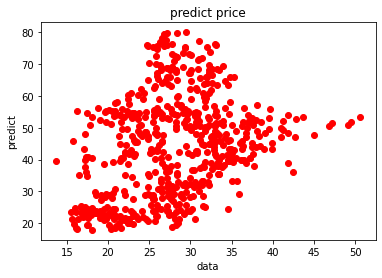

In [124]:
import matplotlib.pyplot as plt
plt.scatter(y_test, pre, c="red")
plt.xlabel("data")
plt.ylabel("predict")
plt.title("predict price")
plt.show()

[Text(279.0, 475.65000000000003, 'Tempdff_MAL_std_of_90days <= 2.656\nmse = 201.521\nsamples = 3507\nvalue = 25.792'),
 Text(139.5, 339.75, 'TMin_CHY <= 14.25\nmse = 144.701\nsamples = 2546\nvalue = 22.184'),
 Text(69.75, 203.85000000000002, 'Temperature_MAL_mean_of_30days <= 24.881\nmse = 97.87\nsamples = 2071\nvalue = 19.892'),
 Text(34.875, 67.94999999999999, '\n  (...)  \n'),
 Text(104.625, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 203.85000000000002, 'Temperature_MAL_mean_of_30days <= 26.695\nmse = 226.229\nsamples = 475\nvalue = 32.087'),
 Text(174.375, 67.94999999999999, '\n  (...)  \n'),
 Text(244.125, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 339.75, 'TMin_CHY <= 12.15\nmse = 227.254\nsamples = 961\nvalue = 35.197'),
 Text(348.75, 203.85000000000002, 'WSGust_HSH <= 12.55\nmse = 120.002\nsamples = 710\nvalue = 31.647'),
 Text(313.875, 67.94999999999999, '\n  (...)  \n'),
 Text(383.625, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 203.85000000000002, 'TMin

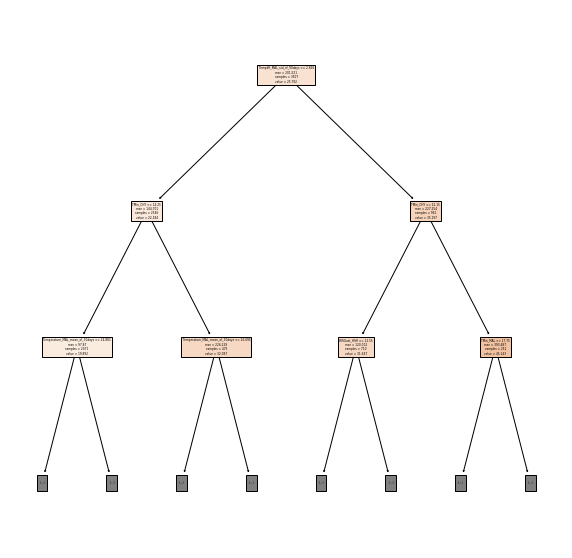

In [125]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
features = new_df.drop(['ans_price'], axis=1).columns
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[2], 
          feature_names=features, 
          class_names=['predict_price'],
          max_depth=2,
          filled=True)

In [135]:
result_df = pd.DataFrame({
    "Name":features,
    "Importance":clf.feature_importances_
}).sort_values(by="Importance", ascending=False)
display(result_df[:10])

,Name,Importance
13,Tempdff_MAL_std_of_90days,0.187470
7,TMin_CHY,0.153474
14,Tempdff_CHY_std_of_90days,0.141355
1,Temperature_TXG_mean_of_30days,0.120850
0,Temperature_MAL_mean_of_30days,0.091494
12,Tempdff_MAL_std_of_30days,0.060923
15,WS_HSC,0.054745
6,TMin_MAL,0.045351
2,Temperature_CWH_mean_of_30days,0.031946
5,TMax_CHY,0.026468


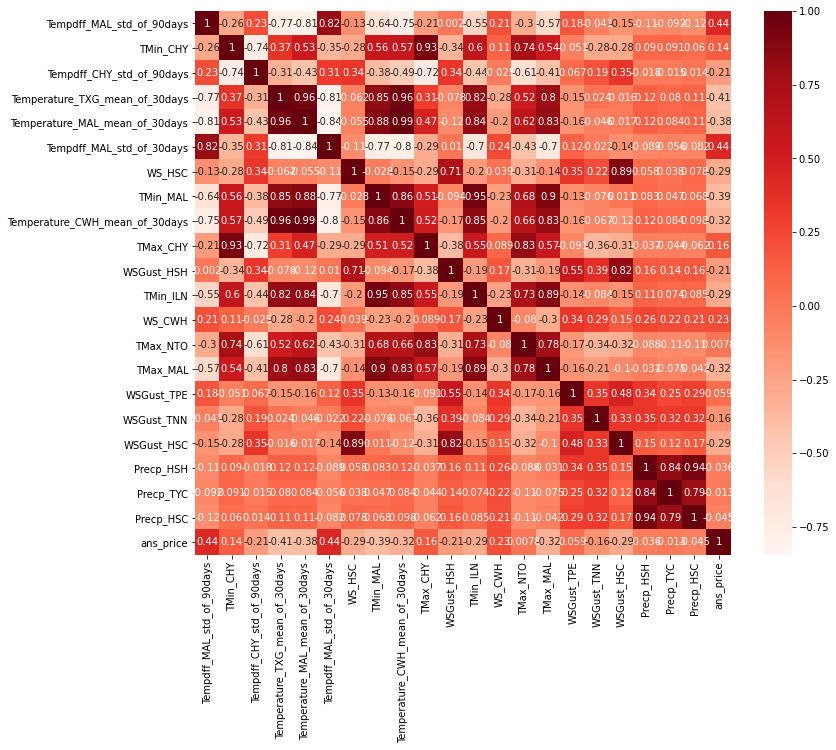

----------


Index(['ans_price'], dtype='object')

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
heatmap_list = list(result_df['Name'])
heatmap_list.append('ans_price')
heatmap_df = merge_df.loc[:,heatmap_list]
# 畫出heatmap
plt.figure(figsize=(12,10))
cor = heatmap_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.savefig('/content/drive/MyDrive/AI課程檔案/專題相關/model/heatmap/heatmap0725.png')
plt.show()

#Correlation with output variable
cor_target = abs(cor["ans_price"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
print('-' * 10)
relevant_features.index

In [143]:
factors = {'Temperature':'溫度', 'TMax':'最高溫', 'TMin':'最低溫', 'WS_':'風速', 'WSGust':'最大陣風', 'Precp_':'雨量', 'Tempdff': '溫差'}
city = {
    '基隆市':'KLU',
    '臺北市':'TPE',
    '新北市':'TPH',
    '桃園市':'TYC',
    '新竹市':'HSC',
    '新竹縣':'HSH',
    '苗栗縣':'MAL',
    '臺中市':'TXG',
    '彰化縣':'CWH',
    '南投縣':'NTO',
    '雲林縣':'YLH',
    '嘉義市':'CYI',
    '嘉義縣':'CHY',
    '臺南市':'TNN',
    '高雄市':'KHH',
    '屏東縣':'IUH',
    '宜蘭縣':'ILN',
    '花蓮縣':'HWA',
    '臺東縣':'TTT'
}

for i in result_df.index:
  title = result_df.Name[i]
  for key, value in factors.items():
    if key in title:
      title = title.replace(key, value)
  for key, value in city.items():
    if value in title:
      title = title.replace(value, key)
  result_df.loc[[i], ['Name']]=title
result_df

,Name,Importance
10,雨量新竹市,0.001100
11,雨量新竹縣,0.002445
9,雨量桃園市,0.002046
5,最高溫_嘉義縣,0.026468
3,最高溫_苗栗縣,0.007424
4,最高溫_南投縣,0.007935
7,最低溫_嘉義縣,0.153474
8,最低溫_宜蘭縣,0.014801
6,最低溫_苗栗縣,0.045351
14,溫差_嘉義縣_std_of_90days,0.141355


In [144]:
pd.set_option('display.max_row', None)
result_df.sort_values(by=['Name'], inplace=True)
result_df

,Name,Importance
7,最低溫_嘉義縣,0.153474
8,最低溫_宜蘭縣,0.014801
6,最低溫_苗栗縣,0.045351
19,最大陣風_新竹市,0.005090
20,最大陣風_新竹縣,0.024986
18,最大陣風_臺北市,0.006182
17,最大陣風_臺南市,0.005472
4,最高溫_南投縣,0.007935
5,最高溫_嘉義縣,0.026468
3,最高溫_苗栗縣,0.007424


In [129]:
# # 儲存上面表格的檔案
# result_df.to_csv('/content/drive/MyDrive/AI課程檔案/專題相關/重要性(clf0710_ver9).csv')

In [130]:
# 預測跨模型比較的測試集
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
a, b = np.array(test_df.drop(['ans_price'], axis=1)), np.array(test_df['ans_price'])
pre = clf.predict(a)
result_df = pd.DataFrame({
    "data_price":b,
    "predict_price":pre
})
r2 = r2_score(b, pre)
MSE = mean_squared_error(b, pre)
RMSE = np.sqrt(MSE)
print('r2 score:',r2)
print('mse score:',MSE)
print('rmse:', RMSE)
display(result_df.head())

r2 score: -31.051311267698907
mse score: 610.9175275733057
rmse: 24.7167458936913


,data_price,predict_price
0,22.8,19.434218
1,19.5,19.562017
2,16.9,18.216364
3,15.1,19.042227
4,14.2,19.673815


In [131]:
# 把上面的結果畫出來
import matplotlib.pyplot as plt
plt.plot(temp_df.index, temp_df.Avg_price, label = "data")
plt.plot(temp_df.index, pre, label = "predict")
plt.title("2020-2021 price") # title
plt.ylabel("price") # y label
plt.xlabel("date") # x label
plt.legend() # 圖例的說明
plt.show()

AttributeError: ignored